# Simple Analysis Imaging Data

### Check configuration file

In [2]:
from scripts.conf_file_finding import try_find_conf_file
try_find_conf_file()

Local configuration file found !!, no need to run the configuration (unless configuration has changed)


If configuration not found run the configuration notebook:
[00-Set-up-configuration](00-Set-up-configuration.ipynb) 

In [3]:
import os 
import datajoint as dj
import numpy as np
import pandas as pd
from u19_pipeline import acquisition, subject
from u19_pipeline.imaging_element import imaging_element, scan_element, get_suite2p_dir
from u19_pipeline.ingest.imaging_element_ingest import process_scan
import pathlib
import matplotlib.pyplot as plt

imaging = dj.create_virtual_module('imaging', 'u19_imaging')
behavior = dj.create_virtual_module('behavior', 'u19_behavior')

Connecting alvaros@datajoint00.pni.princeton.edu:3306


## Session to analyze

In [4]:
subject = 'jeremyjc_j016'
date = '2021-11-21'

key = (imaging.Scan & dict(session_date =date, subject_fullname=subject)).fetch1('KEY')

## Fetch all data

In [5]:
cols_sync = ['sync_im_frame', 'sync_im_frame_global', 'sync_behav_block_by_im_frame', 'sync_behav_trial_by_im_frame', 'sync_behav_iter_by_im_frame', 'sync_im_frame_span_by_behav_block'] 
sync_data     = pd.DataFrame((imaging.SyncImagingBehavior & key).fetch(*cols_sync, as_dict=True))
mask_data     = pd.DataFrame((imaging_element.MaskClassification.MaskType & key).fetch(as_dict=True))
trace_data    = pd.DataFrame((imaging_element.Fluorescence.Trace & key).fetch(as_dict=True))
behavior_data = pd.DataFrame((behavior.TowersBlock.Trial & key).fetch(as_dict=True))

## Sort mask data from highest to lowest confidence, plot highest confidence mask trace

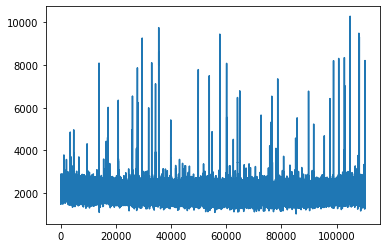

In [55]:
#Which mask shall we use for plots
idx_mask = 1

mask_data = mask_data.sort_values(by=['confidence'], ascending=[False])
mask_data = mask_data.reset_index(drop=True)
plt.plot(trace_data.loc[trace_data['mask'] == mask_data.loc[idx_mask, 'mask'], 'fluorescence'].values[0])

## Get session block with more trials 

In [59]:
blocks_imaging_data = np.unique(sync_data.loc[0, 'sync_behav_block_by_im_frame'])
blocks_imaging_data = np.delete(blocks_imaging_data, 0)

trials_block = behavior_data[['block', 'trial_idx']].copy()
trials_block = trials_block.loc[trials_block['block'].isin(blocks_imaging_data), :]
trials_block_group = trials_block.groupby(by=['block']).count()
trials_block_group = trials_block_group.reset_index()
trials_block_group.sort_values(by=['trial_idx'], ascending=[False])
trials_block_group.reset_index(drop=True)
sel_block = trials_block_group.loc[0, 'block']

trials_sel_block = behavior_data.loc[behavior_data['block'] == sel_block, :]
trials_sel_block = trials_sel_block.reset_index(drop=True)

#Samples imaging of the selected block
idx_samples_block      = np.where(np.squeeze(sync_data.loc[0, 'sync_behav_block_by_im_frame']) == sel_block)
imaging_trial_data_idx = np.squeeze(sync_data.loc[0, 'sync_behav_trial_by_im_frame'])[idx_samples_block]
imaging_iter_data_idx  = np.squeeze(sync_data.loc[0, 'sync_behav_iter_by_im_frame'])[idx_samples_block]
fluorescence_data      = trace_data.loc[trace_data['mask'] == mask_data.loc[idx_mask, 'mask'], 'fluorescence'].values[0][idx_samples_block]


## Get corresponding trace mean for each position for each trial on the block

In [60]:

trace_vec = list()
position_vec = list()
for i in range(trials_sel_block.shape[0]):

    idx_trial = np.where(imaging_trial_data_idx == i+1)
    iters_trial = imaging_iter_data_idx[idx_trial]
    fluorescence_trial = fluorescence_data[idx_trial]
    position_vec_trial = trials_sel_block.loc[trials_sel_block['trial_idx'] == i+1, 'position'].values[0]
    sensor_dots        = trials_sel_block.loc[trials_sel_block['trial_idx'] == i+1, 'sensor_dots'].values[0]
    iter_in_trial      = trials_sel_block.loc[trials_sel_block['trial_idx'] == i+1, 'iterations'].values[0]

    unique_iter = np.unique(iters_trial)

    for idx, iter in enumerate(unique_iter):



        if iter <= iter_in_trial:
            curr_iter = np.where(iters_trial == iter)
            trace_iter = fluorescence_trial[curr_iter[0]]
        
            trace_vec.append(np.mean(trace_iter))  
            position_vec.append(position_vec_trial[int(iter)-1,1])


trace_vec    = np.asarray(trace_vec)
position_vec = np.asarray(position_vec)


## Plot scatter position vs trace

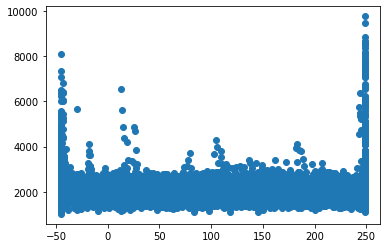

In [61]:
plt.scatter(position_vec, trace_vec)